## Analyze whether early or late snow changes more year to year or place to place.

* We know from previous notebooks that the value of `coef_2` corresponds to whether the snow season is early or late. 
* We want to study whether early/late season is more dependent on the year or on the location.
* We will use RMS Error to quantify the strength of these dependencies.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
%pylab inline
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
### Read the data frame from pickle file

data_dir='../Data/Weather'
state='NY'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [6]:
#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())


8174


In [7]:
tmp=df.filter(df.Station=='USC00306411').toPandas()
tmp.head(1)

,Station,Measurement,Values,Year,coeff_1,coeff_2,coeff_3,coeff_4,coeff_5,dist_coast,...,longitude,name,res_1,res_2,res_3,res_4,res_5,res_mean,total_var,State
0,USC00306411,SNWD,"[0, 126, 0, 126, 0, 126, 0, 126, 0, 126, 0, 12...",1941,1.335004,1.636196,20.11617,-19.059189,-6.872523,370.621002,...,-74.833298,PARISHVILLE 1 WNW,0.999985,0.999962,0.996677,0.995718,0.995049,0.538214,433356.0,NY


In [8]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


,station,year,coeff_2
0,USW00014735,1939,-169.322319
1,USW00014735,1943,272.354092
2,USW00014735,1945,790.579389
3,USW00014735,1947,-216.302832
4,USW00014735,1948,1028.612179


In [9]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station,USC00300015,USC00300023,USC00300047,USC00300055,USC00300063,USC00300077,USC00300085,USC00300090,USC00300093,USC00300159,...,USW00014786,USW00014797,USW00014798,USW00094704,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,870.773867,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-31.805303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,-120.642691,472.534062,NaN,NaN,NaN,907.925667,NaN,...,NaN,NaN,NaN,NaN,NaN,806.258001,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,149.013363,NaN,NaN,0.977231,NaN,97.643753,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0,0.5,'Number of stations')

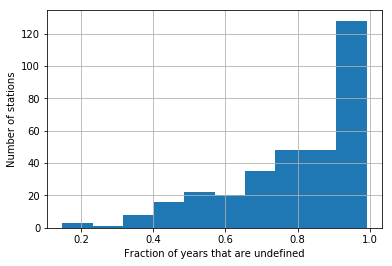

In [10]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0,0.5,'fraction of stations that are undefined')

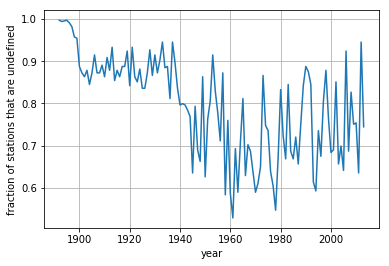

In [11]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [12]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station,USC00300023,USC00300055,USC00300063,USC00300077,USC00300085,USC00300093,USC00300183,USC00300220,USC00300321,USC00300331,...,USW00014768,USW00014771,USW00014786,USW00014798,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
2009,NaN,NaN,NaN,NaN,NaN,870.773867,576.598705,NaN,580.459651,NaN,...,NaN,627.812099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,-31.805303,-25.393217,NaN,-188.964850,-531.836350,...,-177.099611,156.548016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,-120.642691,472.534062,NaN,NaN,907.925667,305.092413,NaN,561.781691,566.875416,...,283.597976,584.134272,NaN,NaN,NaN,806.258001,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,149.013363,NaN,0.977231,NaN,97.643753,NaN,NaN,NaN,170.083352,43.373130,...,15.194207,86.764841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0,0.5,'Number of stations')

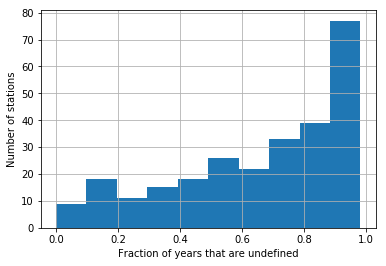

In [13]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [14]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  753.145449514645
RMS removing mean-by-station=  701.5445524111517 reduction= 51.60089710349325
RMS removing mean-by-year   =  531.4823870967627 reduction= 221.6630624178822


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* We can use **alternating minimization** to remove the combined effect of location and time.

In [15]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 753.145449514645
0 after removing mean by year    = 531.4823870967627
0 after removing mean by stations= 490.58111029852466
1 after removing mean by year    = 490.11149394795615
1 after removing mean by stations= 490.0833393502776
2 after removing mean by year    = 490.08010695597295
2 after removing mean by stations= 490.07946790083065
3 after removing mean by year    = 490.0793022334803
3 after removing mean by stations= 490.0792548676868
4 after removing mean by year    = 490.0792408655066
4 after removing mean by stations= 490.0792366758466


In [16]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1961   -0.115733
1962   -0.142607
1963   -0.143292
1964   -0.149812
1965   -0.130511
Name: mean_by_year, dtype: float64

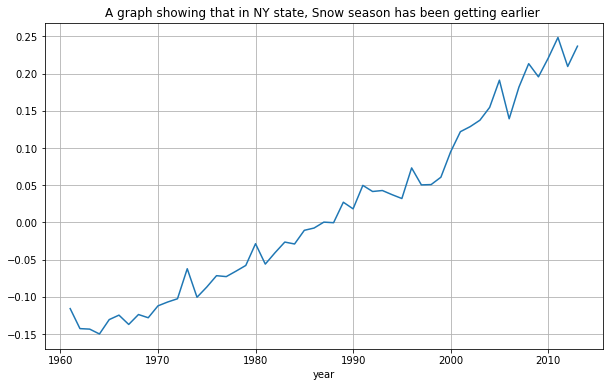

In [17]:
figure(figsize=(10,6))
T['mean_by_year'].plot();
grid()
title('A graph showing that in NY state, Snow season has been getting earlier ');

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY has been getting earlier and earlier since 1960.